## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [6]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_l1l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1= l1_ratio,l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1= l1_ratio,l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8]
L2_EXP = [1e-2, 1e-4, 1e-8]

In [9]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 268us/step - loss: 6.0026 - acc: 0.2689 - val_loss: 5.8167 - val_acc: 0.3375
Epoch 2/50
50000/50000 [==============================] - 13s 263us/step - loss: 5.7234 - acc: 0.3610 - val_loss: 5.6410 - val_acc: 0.3844
Epoch 3/50
50000/50000 [==============================] - 13s 258us/step - loss: 5.5791 - acc: 0.3926 - val_loss: 5.5217 - val_acc: 0.3979
Epoch 4/50
50000/50000 [==============================] - 12s 246us/step - loss: 5.4594 - acc: 0.4123 - val_loss: 5.4115 - val_acc: 0.4165
Epoch 5/50
50000/50000 [==============================] - 12s 246us/step - loss: 5.3474 - acc: 0.4307 - val_loss: 5.3170 - val_acc: 0.4323
Epoch 6/50
50000/50000 [==============================] - 12s 247us/step - loss: 5.2465 - acc: 0.4445 - val_loss: 5.2075 - val_acc: 0.4497
Epoch 7/50
50000/50000 [==============================] - 12s 246us/step - loss: 5.1504 - acc: 0.4560 - val_loss: 5.

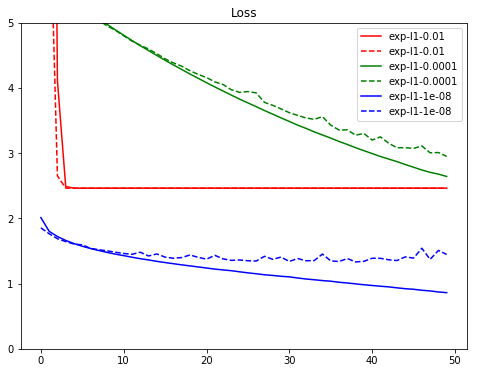

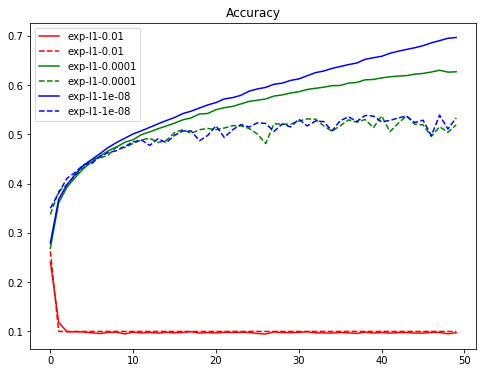

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [12]:
results = {}
for l1_ratio in L1_EXP:
    for l2_ratio in L2_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Experiment with L1 Regulizer = {l1_ratio}, L2 = {l2_ratio}")
        model = build_mlp_l1l2(input_shape=x_train.shape[1:], l1_ratio=l1_ratio, l2_ratio=l2_ratio )
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
    # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 Regulizer = 0.01, L2 = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 284us/step - loss: 198.7898 - acc: 0.2161 - val_loss: 41.1169 - val_acc: 0.2409
Epoch 2/50
50000/50000 [==============================] - 13s 268us/step - loss: 19.1294 - acc: 0.1172 - val_loss: 7.3030 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 13s 268us/step - loss: 4.1213 - acc: 0.0965 - val_loss: 2.6472 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 13s 266us/step - loss: 2.4855 - acc: 0.0982 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 13s 269us/step - loss: 2.4626 - acc: 0.0978 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 13s 267us/step - loss: 2.4626 - acc: 0.0988 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 13s 267us/step - loss: 2.4626 - acc: 0.0982 - val_loss

50000/50000 [==============================] - 14s 287us/step - loss: 18.8120 - acc: 0.2615 - val_loss: 17.3515 - val_acc: 0.3353
Epoch 2/50
50000/50000 [==============================] - 14s 284us/step - loss: 16.1374 - acc: 0.3545 - val_loss: 14.9700 - val_acc: 0.3691
Epoch 3/50
50000/50000 [==============================] - 14s 271us/step - loss: 13.9533 - acc: 0.3769 - val_loss: 12.9752 - val_acc: 0.3861
Epoch 4/50
50000/50000 [==============================] - 14s 271us/step - loss: 12.1073 - acc: 0.3890 - val_loss: 11.2722 - val_acc: 0.3999
Epoch 5/50
50000/50000 [==============================] - 14s 283us/step - loss: 10.5375 - acc: 0.4008 - val_loss: 9.8258 - val_acc: 0.4088
Epoch 6/50
50000/50000 [==============================] - 14s 272us/step - loss: 9.2026 - acc: 0.4066 - val_loss: 8.5972 - val_acc: 0.4159
Epoch 7/50
50000/50000 [==============================] - 14s 273us/step - loss: 8.0642 - acc: 0.4140 - val_loss: 7.5515 - val_acc: 0.4118
Epoch 8/50
50000/50000 [=====

Epoch 2/50
50000/50000 [==============================] - 14s 275us/step - loss: 5.7176 - acc: 0.3650 - val_loss: 5.6326 - val_acc: 0.3863
Epoch 3/50
50000/50000 [==============================] - 14s 276us/step - loss: 5.5706 - acc: 0.3936 - val_loss: 5.5077 - val_acc: 0.4126
Epoch 4/50
50000/50000 [==============================] - 14s 276us/step - loss: 5.4512 - acc: 0.4133 - val_loss: 5.3931 - val_acc: 0.4210
Epoch 5/50
50000/50000 [==============================] - 14s 277us/step - loss: 5.3425 - acc: 0.4312 - val_loss: 5.2988 - val_acc: 0.4300
Epoch 6/50
50000/50000 [==============================] - 14s 275us/step - loss: 5.2424 - acc: 0.4444 - val_loss: 5.2115 - val_acc: 0.4401
Epoch 7/50
50000/50000 [==============================] - 14s 274us/step - loss: 5.1499 - acc: 0.4541 - val_loss: 5.1279 - val_acc: 0.4461
Epoch 8/50
50000/50000 [==============================] - 14s 276us/step - loss: 5.0591 - acc: 0.4642 - val_loss: 5.0346 - val_acc: 0.4557
Epoch 9/50
50000/50000 [===

Epoch 3/50
50000/50000 [==============================] - 14s 289us/step - loss: 11.3399 - acc: 0.3867 - val_loss: 10.5883 - val_acc: 0.3928
Epoch 4/50
50000/50000 [==============================] - 15s 299us/step - loss: 9.9274 - acc: 0.3992 - val_loss: 9.2884 - val_acc: 0.4033
Epoch 5/50
50000/50000 [==============================] - 14s 289us/step - loss: 8.7284 - acc: 0.4110 - val_loss: 8.1918 - val_acc: 0.4069
Epoch 6/50
50000/50000 [==============================] - 14s 279us/step - loss: 7.7062 - acc: 0.4163 - val_loss: 7.2430 - val_acc: 0.4221
Epoch 7/50
50000/50000 [==============================] - 14s 277us/step - loss: 6.8343 - acc: 0.4252 - val_loss: 6.4415 - val_acc: 0.4291
Epoch 8/50
50000/50000 [==============================] - 14s 276us/step - loss: 6.0912 - acc: 0.4294 - val_loss: 5.7602 - val_acc: 0.4258
Epoch 9/50
50000/50000 [==============================] - 14s 276us/step - loss: 5.4550 - acc: 0.4352 - val_loss: 5.1679 - val_acc: 0.4394
Epoch 10/50
50000/50000 [

Epoch 4/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.8158 - acc: 0.4115 - val_loss: 1.8034 - val_acc: 0.4126
Epoch 5/50
50000/50000 [==============================] - 14s 283us/step - loss: 1.7665 - acc: 0.4292 - val_loss: 1.7574 - val_acc: 0.4276
Epoch 6/50
50000/50000 [==============================] - 14s 282us/step - loss: 1.7250 - acc: 0.4435 - val_loss: 1.7174 - val_acc: 0.4447
Epoch 7/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.6884 - acc: 0.4564 - val_loss: 1.6955 - val_acc: 0.4509
Epoch 8/50
50000/50000 [==============================] - 14s 280us/step - loss: 1.6565 - acc: 0.4667 - val_loss: 1.6697 - val_acc: 0.4571
Epoch 9/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.6288 - acc: 0.4753 - val_loss: 1.6511 - val_acc: 0.4620
Epoch 10/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.6009 - acc: 0.4850 - val_loss: 1.6318 - val_acc: 0.4715
Epoch 11/50
50000/50000 [=

Epoch 5/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.6187 - acc: 0.4323 - val_loss: 1.6091 - val_acc: 0.4359
Epoch 6/50
50000/50000 [==============================] - 15s 306us/step - loss: 1.5793 - acc: 0.4464 - val_loss: 1.5704 - val_acc: 0.4491
Epoch 7/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.5454 - acc: 0.4591 - val_loss: 1.5564 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.5164 - acc: 0.4686 - val_loss: 1.5365 - val_acc: 0.4588
Epoch 9/50
50000/50000 [==============================] - 14s 278us/step - loss: 1.4881 - acc: 0.4790 - val_loss: 1.5152 - val_acc: 0.4637
Epoch 10/50
50000/50000 [==============================] - 14s 283us/step - loss: 1.4626 - acc: 0.4863 - val_loss: 1.4808 - val_acc: 0.4804
Epoch 11/50
50000/50000 [==============================] - 14s 285us/step - loss: 1.4380 - acc: 0.4969 - val_loss: 1.4614 - val_acc: 0.4873
Epoch 12/50
50000/50000 [

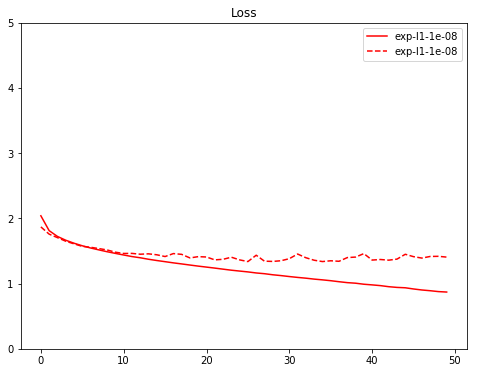

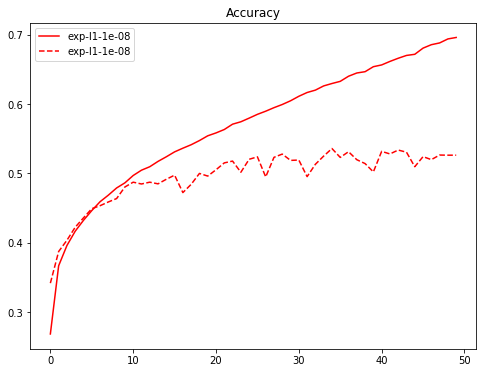

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k",'cyan','orange','purple']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()